## Decision-tree based algorithms for prediction

In this part of the work, we will try to train decision-tree based algorithms to make predicitions about the timeline.

### Building feature extraction pipeline

Tree-based algorithms would require feature selection, so we will need to use a reasonable number of features. We will start by including 300 best features using our tokenization pipeline.

In [2]:
# Save the work into a dedicated workspace "ridge"
disk_tree = "tree"
import os
if not os.path.exists(disk_tree):
    os.makedirs(disk_tree) 

In [1]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MaxAbsScaler,FunctionTransformer, Imputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import HashingVectorizer

# First we build two utility functions to parse numeric and text data, 
# and wrap them using FunctionTransformer, so that they can be integrated into a sklearn pipeline:
def text_columns(X_train):
    return X_train.TEXT_FEATURES

def numeric_columns(X_train):
    numeric = ['APPLICANT_PRIOR_CLEARANCE_TO_DATE','DEVICENAME_PRIOR_CLEARANCE_TO_DATE']
    temp = X_train[numeric]
    return temp

get_numeric_data = FunctionTransformer(func = numeric_columns, validate=False) 
get_text_data = FunctionTransformer(func = text_columns,validate=False) 
# Note how we avoid putting any arguments into text_columns and numeric_columns

# We also need to create our regex token pattern to use in HashingVectorizer. 
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'   
#Note this regex will match either a whitespace or a punctuation to tokenize the string vector on these preferences  

# We also need to redefine the default feature selection function for regression to properly place into our pipeline:
def f_regression(X,Y):
    import sklearn
    return sklearn.feature_selection.f_regression(X,Y,center = False) # default is center = True


pipeline510k_tree1 = Pipeline([
    
    ("union",FeatureUnion( # Note that FeatureUnion() accepts list of tuples, the first half of each tuple is the name of the transformer
        
        transformer_list = [
            
            ("numeric_subpipeline", Pipeline([ # Note we have subpipeline branches inside the main pipeline
                
                ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                ("imputer",Imputer()), # Step2: impute missing values (we don't expect any)
            
            ])), # Branching point of the FeatureUnion
            
            ("text_subpipeline",Pipeline([
            
                ("parser",get_text_data), # Step1: parse the text data 
                ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC,n_features= 2 ** 18,decode_error='ignore',
                                             stop_words = "english",# We will remove English stop words before tokenization
                                             ngram_range = (1,1), # We will tokenize to single words only
                                             non_negative=True, norm=None, binary=True  
                                            )) # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                           
                
            ]))
        ]
    
    )),# Branching point to the main pipeline: at this point all features are numeric
    
    ("scaler",MaxAbsScaler()), # Scale the features
    ("dim_red", SelectKBest(f_regression, 300))
])


In [3]:
import pickle
# Load Training and Validation sets
disk = "D:\Data_science\GitHub\Predictive-Modeling-510k-decision-time"
# Validation set 
with open(disk+"\X_val.pkl","rb") as f:
    X_val=pickle.load(f)

with open(disk+"\y_val.pkl","rb") as f:
    y_val=pickle.load(f)
    
# Training set (Locked down)
with open(disk+"\X_train.pkl","rb") as f:
    X_train=pickle.load(f)

with open(disk+"\y_train.pkl","rb") as f:
    y_train=pickle.load(f) 

In [3]:
import datetime
from warnings import filterwarnings

filterwarnings("ignore")

start = datetime.datetime.now()

X_train_trans_tree = pipeline510k_tree1.fit(X_train, y_train).transform(X_train)

end = datetime.datetime.now()
print("Completed processing X_train in: " + str((end-start).seconds/60) + " minutes.")

start = datetime.datetime.now()

X_val_trans_tree = pipeline510k_tree1.transform(X_val)

end = datetime.datetime.now()
print("Completed processing X_val in: " + str((end-start).seconds/60) + " minutes.")

Completed processing X_train in: 0.7833333333333333 minutes.
Completed processing X_val in: 0.18333333333333332 minutes.


In [4]:
print(X_train_trans_tree.shape)
print(X_val_trans_tree.shape)

(32275, 300)
(15899, 300)


### Gradient Boosting Regresion

We will first train an untuned Gradient Boosting algorithm to see performance.

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import median_absolute_error
import numpy as np
import datetime
import warnings

start = datetime.datetime.now()

gbm1 = GradientBoostingRegressor(verbose = 1, n_estimators= 200, max_depth=5)

gbm1.fit(X_train_trans_tree, np.log(y_train))
preds = gbm1.predict(X_val_trans_tree)

mae = median_absolute_error(y_val,np.exp(preds))

end = datetime.datetime.now()
print("Median Absolute Error: ", str(mae))
print("Completed model fit and predictions in: " + str((end-start).seconds/60) + " minutes.")

      Iter       Train Loss   Remaining Time 
         1           0.7446            2.62m
         2           0.7138            2.48m
         3           0.6883            2.46m
         4           0.6669            2.41m
         5           0.6498            2.41m
         6           0.6349            2.42m
         7           0.6224            2.42m
         8           0.6123            2.42m
         9           0.6037            2.40m
        10           0.5963            2.40m
        20           0.5585            2.29m
        30           0.5420            2.15m
        40           0.5296            2.01m
        50           0.5196            1.89m
        60           0.5103            1.76m
        70           0.5023            1.63m
        80           0.4953            1.48m
        90           0.4888            1.35m
       100           0.4827            1.21m
       200           0.4350            0.00s
Median Absolute Error:  37.452053685765335
Completed m

#### Hyperparameter Tuning

In [18]:
import numpy as np
from sklearn.model_selection import GridSearchCV

start = datetime.datetime.now()

param_grid = {
    'n_estimators' : [100,500,1000],
    'max_depth':[5,10,15],
    'learning_rate': [0.1,0.25,0.75,1]
}

# We have 8 CPU cores, we will use 6 for this task
gbmSearch1 = GridSearchCV(estimator= GradientBoostingRegressor(), 
                            param_grid= param_grid,
                            n_jobs = 6,
                            cv = 3,
                            verbose = 10, scoring= 'neg_median_absolute_error'
                            )
gbmSearch1.fit(X_train_trans_tree, np.log(y_train))

end = datetime.datetime.now()
print("Completed GridSearch in: " + str((end-start).seconds/60) + " minutes.")

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed: 49.8min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 75.3min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 115.8min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 125.9min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed: 170.8min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed: 183.3min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed: 204.8min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed: 217.8min
[Parallel(n_jobs=6)]: Done 108 out of 108 | elapsed: 250.9min remaining:    0.0s
[Parallel(n_jobs=6)]: Done 108 out of 108 | elapsed: 250.9min finished


Completed GridSearch in: 259.8333333333333 minutes.


In [19]:
gbmSearch1.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=10, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [20]:
from sklearn.metrics import median_absolute_error
# Let's see the validation MAE (in original target scale) from the best estimator
preds = gbmSearch1.best_estimator_.predict(X_val_trans_tree)
median_absolute_error(y_val,np.exp(preds))

37.38059952933966

### Light Gradient Boosting

Let's try to use relatively new ligtGBM package to see the performance. The package has a sklearn interface we will use to perform hyperparameter optimization as well.

In [6]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import median_absolute_error
import datetime
import warnings

start = datetime.datetime.now()

lgbm1 = lgb.LGBMRegressor(objective= 'regression')

lgbm1.fit(X_train_trans_tree, np.log(y_train))
preds = lgbm1.predict(X_val_trans_tree)

mae = median_absolute_error(y_val,np.exp(preds))

end = datetime.datetime.now()
print("Median Absolute Error: ", str(mae))
print("Completed model fit and predictions in: " + str((end-start).seconds/60) + " minutes.")


Median Absolute Error:  36.951519001311084
Completed model fit and predictions in: 0.016666666666666666 minutes.


We notice that lightGBM is indeed extremely faster and performed better than even the tuned traditional GBM. We will experiment this algorithm and attempt hyperparameter optimization. Let's define a new pipeline without feature selection to also experiment the impact of adding more features on model performance.

In [73]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MaxAbsScaler,FunctionTransformer, Imputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import HashingVectorizer

# First we build two utility functions to parse numeric and text data, 
# and wrap them using FunctionTransformer, so that they can be integrated into a sklearn pipeline:
def text_columns(X_train):
    return X_train.TEXT_FEATURES

def numeric_columns(X_train):
    numeric = ['APPLICANT_PRIOR_CLEARANCE_TO_DATE','DEVICENAME_PRIOR_CLEARANCE_TO_DATE']
    temp = X_train[numeric]
    return temp

get_numeric_data = FunctionTransformer(func = numeric_columns, validate=False) 
get_text_data = FunctionTransformer(func = text_columns,validate=False) 
# Note how we avoid putting any arguments into text_columns and numeric_columns

# We also need to create our regex token pattern to use in HashingVectorizer. 
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'   
#Note this regex will match either a whitespace or a punctuation to tokenize the string vector on these preferences  

# We also need to redefine the default feature selection function for regression to properly place into our pipeline:
def f_regression(X,Y):
    import sklearn
    return sklearn.feature_selection.f_regression(X,Y,center = False) # default is center = True


pipeline510k_tree2 = Pipeline([
    
    ("union",FeatureUnion( # Note that FeatureUnion() accepts list of tuples, the first half of each tuple is the name of the transformer
        
        transformer_list = [
            
            ("numeric_subpipeline", Pipeline([ # Note we have subpipeline branches inside the main pipeline
                
                ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                ("imputer",Imputer()), # Step2: impute missing values (we don't expect any)
            
            ])), # Branching point of the FeatureUnion
            
            ("text_subpipeline",Pipeline([
            
                ("parser",get_text_data), # Step1: parse the text data 
                ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC,n_features= 2 ** 18,decode_error='ignore',
                                             stop_words = "english",# We will remove English stop words before tokenization
                                             ngram_range = (1,1), # We will tokenize to single words only
                                             non_negative=True, norm=None, binary=True  
                                            )) # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                           
                
            ]))
        ]
    
    )),# Branching point to the main pipeline: at this point all features are numeric
    
    ("scaler",MaxAbsScaler()) # Scale the features
])


In [74]:
import datetime
from warnings import filterwarnings

filterwarnings("ignore")

start = datetime.datetime.now()

X_train_trans_tree2 = pipeline510k_tree2.fit(X_train, y_train).transform(X_train)

end = datetime.datetime.now()
print("Completed processing X_train in: " + str((end-start).seconds/60) + " minutes.")

start = datetime.datetime.now()

X_val_trans_tree2 = pipeline510k_tree2.transform(X_val)

end = datetime.datetime.now()
print("Completed processing X_val in: " + str((end-start).seconds/60) + " minutes.")

Completed processing X_train in: 0.75 minutes.
Completed processing X_val in: 0.18333333333333332 minutes.


In [75]:
print(X_train_trans_tree2.shape)
print(X_val_trans_tree2.shape)

(32275, 262146)
(15899, 262146)


In [79]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import median_absolute_error
import datetime
import warnings

Xt = SelectKBest(f_regression,10000).fit(X_train_trans_tree2,y_train).transform(X_train_trans_tree2)
Xv = SelectKBest(f_regression,10000).fit(X_train_trans_tree2,y_train).transform(X_val_trans_tree2)

start = datetime.datetime.now()

lgbm1 = lgb.LGBMRegressor(objective= 'regression', num_leaves= 300,
                          n_estimators=200, reg_alpha= 0.1,
                          boosting_type= 'dart')

lgbm1.fit(Xt, np.log(y_train))
preds = lgbm1.predict(Xv)

mae = median_absolute_error(y_val,np.exp(preds))

end = datetime.datetime.now()
print("Median Absolute Error: ", str(mae))
print("Completed model fit and predictions in: " + str((end-start).seconds/60) + " minutes.")


Median Absolute Error:  29.467624324930185
Completed model fit and predictions in: 1.3666666666666667 minutes.


It looks like lgbm is robust to overfitting when adding more features. Let's try to first search for the number of features to be included in the fixed model.

In [83]:
n_features_list = [300,5000,10000,20000,50000,100000,200000,262146]
mae_list = []
time_list = []

for n_features in n_features_list:
    print("Training model using "+ str(n_features))
    
    # Testing feature selection based on training set
    Xt = SelectKBest(f_regression,n_features).fit(X_train_trans_tree2,y_train).transform(X_train_trans_tree2)
    Xv = SelectKBest(f_regression,n_features).fit(X_train_trans_tree2,y_train).transform(X_val_trans_tree2)

    start = datetime.datetime.now()
    
    # Fixed model structure 
    lgbm1 = lgb.LGBMRegressor(objective= 'regression', num_leaves= 300,
                              n_estimators=200, reg_alpha= 0.1,
                              boosting_type= 'dart')

    lgbm1.fit(Xt, np.log(y_train))
    preds = lgbm1.predict(Xv)

    # Out-of-box performance using validation set
    mae = median_absolute_error(y_val,np.exp(preds))

    end = datetime.datetime.now()
    
    mae_list.append(mae)
    time_list.append((end-start).seconds/60)

    print("Completed model fit and predictions using "+ str(n_features) + " in: " + str((end-start).seconds/60) + " minutes.")
    print("Median Absolute Error: ", str(mae))
    print("*" * 50)


Training model using 300
Completed model fit and predictions using 300 in: 0.1 minutes.
Median Absolute Error:  33.107162652136324
**************************************************
Training model using 5000
Completed model fit and predictions using 5000 in: 0.8833333333333333 minutes.
Median Absolute Error:  29.633671997998164
**************************************************
Training model using 10000
Completed model fit and predictions using 10000 in: 1.4 minutes.
Median Absolute Error:  29.467624324930185
**************************************************
Training model using 20000
Completed model fit and predictions using 20000 in: 1.6666666666666667 minutes.
Median Absolute Error:  29.30898855444397
**************************************************
Training model using 50000
Completed model fit and predictions using 50000 in: 1.9 minutes.
Median Absolute Error:  29.209825132888795
**************************************************
Training model using 100000
Completed model fit

It looks like model starts to overfit beyond 100000 training features. We will define the new pipeline, transform the data sets before further hyperparameter optimization.

#### Light GBM Feature extraction pipeline

In [40]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MaxAbsScaler,FunctionTransformer, Imputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import HashingVectorizer

# First we build two utility functions to parse numeric and text data, 
# and wrap them using FunctionTransformer, so that they can be integrated into a sklearn pipeline:
def text_columns(X_train):
    return X_train.TEXT_FEATURES

def numeric_columns(X_train):
    numeric = ['APPLICANT_PRIOR_CLEARANCE_TO_DATE','DEVICENAME_PRIOR_CLEARANCE_TO_DATE']
    temp = X_train[numeric]
    return temp

get_numeric_data = FunctionTransformer(func = numeric_columns, validate=False) 
get_text_data = FunctionTransformer(func = text_columns,validate=False) 
# Note how we avoid putting any arguments into text_columns and numeric_columns

# We also need to create our regex token pattern to use in HashingVectorizer. 
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'   
#Note this regex will match either a whitespace or a punctuation to tokenize the string vector on these preferences  

# We also need to redefine the default feature selection function for regression to properly place into our pipeline:
def f_regression(X,Y):
    import sklearn
    return sklearn.feature_selection.f_regression(X,Y,center = False) # default is center = True


pipeline510k_tree3 = Pipeline([
    
    ("union",FeatureUnion( # Note that FeatureUnion() accepts list of tuples, the first half of each tuple is the name of the transformer
        
        transformer_list = [
            
            ("numeric_subpipeline", Pipeline([ # Note we have subpipeline branches inside the main pipeline
                
                ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                ("imputer",Imputer()), # Step2: impute missing values (we don't expect any)
            
            ])), # Branching point of the FeatureUnion
            
            ("text_subpipeline",Pipeline([
            
                ("parser",get_text_data), # Step1: parse the text data 
                ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC,n_features= 2 ** 18,decode_error='ignore',
                                             stop_words = "english",# We will remove English stop words before tokenization
                                             ngram_range = (1,1), # We will tokenize to single words only
                                             non_negative=True, norm=None, binary=True  
                                            )) # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                           
                
            ]))
        ]
    
    )),# Branching point to the main pipeline: at this point all features are numeric
    
    ("scaler",MaxAbsScaler()), # Scale the features
    ("dim_red", SelectKBest(f_regression, 100000))
])


In [41]:
import datetime
from warnings import filterwarnings

filterwarnings("ignore")

start = datetime.datetime.now()

X_train_trans_tree3 = pipeline510k_tree3.fit(X_train, y_train).transform(X_train)

end = datetime.datetime.now()
print("Completed processing X_train in: " + str((end-start).seconds/60) + " minutes.")

start = datetime.datetime.now()

X_val_trans_tree3 = pipeline510k_tree3.transform(X_val)

end = datetime.datetime.now()
print("Completed processing X_val in: " + str((end-start).seconds/60) + " minutes.")

Completed processing X_train in: 0.8 minutes.
Completed processing X_val in: 0.2 minutes.


In [42]:
print(X_train_trans_tree3.shape)
print(X_val_trans_tree3.shape)

(32275, 100000)
(15899, 100000)


#### Light GBM Hyperparameter Tuning using GridSearchCV

In [88]:
import numpy as np
from sklearn.model_selection import GridSearchCV

start = datetime.datetime.now()

param_grid = {
    'n_estimators' : [100,150,200,250,400,500],
    'num_leaves':[150,200,300,400],
    'reg_alpha': [0,0.01,0.05,0.1,0.5,1,5,10],
    'objective': ['regression'],
    'boosting_type': ['dart']
}

# We have 8 CPU cores, we will use 6 for this task
lgbmSearch1 = GridSearchCV(estimator= lgb.LGBMRegressor(), 
                            param_grid= param_grid,
                            n_jobs = 6,
                            cv = 6,
                            verbose = 10, scoring= 'neg_median_absolute_error'
                            )

lgbmSearch1.fit(X_train_trans_tree3, np.log(y_train))

end = datetime.datetime.now()
print("Completed GridSearch in: " + str((end-start).seconds/60) + " minutes.")

Fitting 6 folds for each of 192 candidates, totalling 1152 fits


[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  9.1min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 12.2min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 15.4min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 19.8min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed: 25.5min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed: 30.0min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed: 40.0min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed: 45.6min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed: 53.6min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed: 67.4min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed: 77.6min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 88.1min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed: 109.2min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed: 119.2min
[Parallel(n_jobs=6)]: 

Completed GridSearch in: 467.56666666666666 minutes.


In [89]:
lgbmSearch1.best_estimator_

LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
       n_jobs=-1, num_leaves=150, objective='regression',
       random_state=None, reg_alpha=0.1, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=1)

In [90]:
lgbmSearch1.best_score_

-0.38894595686144295

In [91]:
from sklearn.metrics import median_absolute_error
# Let's see the validation MAE (in original target scale) from the best estimator
preds = lgbmSearch1.best_estimator_.predict(X_val_trans_tree3)
median_absolute_error(y_val,np.exp(preds))

31.504873585145397

#### Bayesian optimization

In [95]:
# We start by defining the score we want to be maximized using Bayesian Optimization
# Return MEAN validated 'roc_auc' score from xgb Classifier
# Note that the 4 parameters we will optimize are called as generic arguments

seed = 112 # Random seed

def lgbm_score(num_leaves,n_estimators,reg_alpha):
    from sklearn.metrics import roc_auc_score
    import numpy as np
    
    lgbm1 = lgb.LGBMRegressor(objective= 'regression', num_leaves= int(num_leaves),
                              n_estimators= int(n_estimators), reg_alpha= reg_alpha,
                              boosting_type= 'dart')

    lgbm1.fit(X_train_trans_tree3, np.log(y_train))
    preds = lgbm1.predict(X_val_trans_tree3)

    # Out-of-box performance using validation set
    mae = median_absolute_error(y_val,np.exp(preds))
    
    # return the - mae to be maximized
    return - mae

In [96]:
import warnings
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization

# alpha is a parameter for the gaussian process
# Note that this is itself a hyperparemter that can be optimized.
gp_params = {"alpha": 1e-10}

# We create the BayesianOptimization objects using the functions that utilize
# the respective classifiers and return cross-validated scores to be optimized.

seed = 112 # Random seed

# We create the bayes_opt object and pass the function to be maximized
# together with the parameters names and their bounds.
# Note the syntax of bayes_opt package: bounds of hyperparameters are passed as two-tuples

hyperparameter_space = {
    'num_leaves': (150, 300),
    'n_estimators' : (150,300),
    'reg_alpha': (0,1)
}

lgbmBO = BayesianOptimization(f = lgbm_score, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

# Finally we call .maximize method of the optimizer with the appropriate arguments
# kappa is a measure of 'aggressiveness' of the bayesian optimization process
# The algorithm will randomly choose 3 points to establish a 'prior', then will perform 
# 10 interations to maximize the value of estimator function
lgbmBO.maximize(init_points=3,n_iter=10,acq='ucb', kappa= 3, **gp_params)

Initialization
---------------------------------------------------------------------------
 Step |   Time |      Value |   n_estimators |   num_leaves |   reg_alpha | 
    1 | 01m16s |  -35.12445 |       161.3516 |     206.2586 |      0.0548 | 
    2 | 01m58s |  -31.10728 |       266.5394 |     246.0457 |      0.8177 | 
    3 | 02m06s |  -30.57605 |       274.9119 |     292.5025 |      0.8854 | 
Bayesian Optimization
---------------------------------------------------------------------------
 Step |   Time |      Value |   n_estimators |   num_leaves |   reg_alpha | 
    4 | 01m47s |  -30.11682 |       300.0000 |     150.0000 |      1.0000 | 
    5 | 03m14s |  -29.74980 |       300.0000 |     300.0000 |      0.0000 | 
    6 | 02m16s |  -30.23047 |       300.0000 |     300.0000 |      1.0000 | 
    7 | 01m38s |  -30.90307 |       150.0000 |     300.0000 |      0.0000 | 
    8 | 01m05s |  -31.16249 |       150.0000 |     150.0000 |      0.0000 | 
    9 | 02m34s |  -29.10945 |       231.1

Bayesian optimization is promising to find parameter that may improve the performance. Let's try another round of optimization cycle by focusing on a narrower hyperparameter space.

In [97]:
import warnings
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization

# alpha is a parameter for the gaussian process
# Note that this is itself a hyperparemter that can be optimized.
gp_params = {"alpha": 1e-10}

# We create the BayesianOptimization objects using the functions that utilize
# the respective classifiers and return cross-validated scores to be optimized.

seed = 112 # Random seed

# We create the bayes_opt object and pass the function to be maximized
# together with the parameters names and their bounds.
# Note the syntax of bayes_opt package: bounds of hyperparameters are passed as two-tuples

hyperparameter_space = {
    'num_leaves': (290, 400),
    'n_estimators' : (220,250),
    'reg_alpha': (0,0.01)
}

lgbmBO = BayesianOptimization(f = lgbm_score, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

# Finally we call .maximize method of the optimizer with the appropriate arguments
# kappa is a measure of 'aggressiveness' of the bayesian optimization process
# The algorithm will randomly choose 3 points to establish a 'prior', then will perform 
# 10 interations to maximize the value of estimator function
lgbmBO.maximize(init_points=5,n_iter=10,acq='ucb', kappa= 3, **gp_params)

Initialization
---------------------------------------------------------------------------
 Step |   Time |      Value |   n_estimators |   num_leaves |   reg_alpha | 
    1 | 02m51s |  -29.02788 |       244.9824 |     331.2563 |      0.0000 | 
    2 | 02m36s |  -29.04927 |       221.6442 |     360.4335 |      0.0098 | 
    3 | 03m05s |  -29.39139 |       244.5303 |     394.5018 |      0.0034 | 
    4 | 02m32s |  -29.36064 |       246.5605 |     298.3245 |      0.0009 | 
    5 | 02m53s |  -29.93163 |       241.6704 |     375.4623 |      0.0039 | 
Bayesian Optimization
---------------------------------------------------------------------------
 Step |   Time |      Value |   n_estimators |   num_leaves |   reg_alpha | 
    6 | 02m18s |  -29.10648 |       220.0000 |     290.0000 |      0.0000 | 
    7 | 02m52s |  -29.40106 |       220.0000 |     400.0000 |      0.0000 | 
    8 | 02m28s |  -29.02445 |       220.0000 |     334.1820 |      0.0100 | 
    9 | 03m13s |  -29.80390 |       250.0

We are able to find parameters that further improved performance. Let's try to further narrow down the hyperparameter space and perform another round of Bayesian Optimization.

In [98]:
import warnings
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization

# alpha is a parameter for the gaussian process
# Note that this is itself a hyperparemter that can be optimized.
gp_params = {"alpha": 1e-10}

# We create the BayesianOptimization objects using the functions that utilize
# the respective classifiers and return cross-validated scores to be optimized.

seed = 112 # Random seed

# We create the bayes_opt object and pass the function to be maximized
# together with the parameters names and their bounds.
# Note the syntax of bayes_opt package: bounds of hyperparameters are passed as two-tuples

hyperparameter_space = {
    'num_leaves': (290, 350),
    'n_estimators' : (200,230),
    'reg_alpha': (0,0.025)
}

lgbmBO = BayesianOptimization(f = lgbm_score, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

# Finally we call .maximize method of the optimizer with the appropriate arguments
# kappa is a measure of 'aggressiveness' of the bayesian optimization process
# The algorithm will randomly choose 3 points to establish a 'prior', then will perform 
# 10 interations to maximize the value of estimator function
lgbmBO.maximize(init_points=5,n_iter=10,acq='ucb', kappa= 3, **gp_params)

Initialization
---------------------------------------------------------------------------
 Step |   Time |      Value |   n_estimators |   num_leaves |   reg_alpha | 
    1 | 02m29s |  -29.10137 |       224.9824 |     312.5034 |      0.0001 | 
    2 | 02m17s |  -29.23025 |       201.6442 |     328.4183 |      0.0245 | 
    3 | 02m34s |  -29.46624 |       224.5303 |     347.0010 |      0.0086 | 
    4 | 02m21s |  -28.79092 |       226.5605 |     294.5406 |      0.0024 | 
    5 | 02m30s |  -29.39501 |       221.6704 |     336.6158 |      0.0099 | 
Bayesian Optimization
---------------------------------------------------------------------------
 Step |   Time |      Value |   n_estimators |   num_leaves |   reg_alpha | 
    6 | 02m05s |  -29.11512 |       200.0636 |     290.0450 |      0.0122 | 
    7 | 02m30s |  -28.87265 |       230.0000 |     290.0000 |      0.0000 | 
    8 | 02m22s |  -29.21013 |       200.0000 |     350.0000 |      0.0250 | 
    9 | 02m20s |  -29.08370 |       220.0

Initialization stage give us another lead for optimization. We will perform another round of optimization cycle using these 3 parameters.

In [99]:
import warnings
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization

# alpha is a parameter for the gaussian process
# Note that this is itself a hyperparemter that can be optimized.
gp_params = {"alpha": 1e-10}

# We create the BayesianOptimization objects using the functions that utilize
# the respective classifiers and return cross-validated scores to be optimized.

seed = 112 # Random seed

# We create the bayes_opt object and pass the function to be maximized
# together with the parameters names and their bounds.
# Note the syntax of bayes_opt package: bounds of hyperparameters are passed as two-tuples

hyperparameter_space = {
    'num_leaves': (270, 295),
    'n_estimators' : (200,230),
    'reg_alpha': (0,0.005)
}

lgbmBO = BayesianOptimization(f = lgbm_score, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

# Finally we call .maximize method of the optimizer with the appropriate arguments
# kappa is a measure of 'aggressiveness' of the bayesian optimization process
# The algorithm will randomly choose 3 points to establish a 'prior', then will perform 
# 10 interations to maximize the value of estimator function
lgbmBO.maximize(init_points=5,n_iter=10,acq='ucb', kappa= 3, **gp_params)

Initialization
---------------------------------------------------------------------------
 Step |   Time |      Value |   n_estimators |   num_leaves |   reg_alpha | 
    1 | 02m20s |  -28.92014 |       224.9824 |     279.3764 |      0.0000 | 
    2 | 02m01s |  -29.27668 |       201.6442 |     286.0076 |      0.0049 | 
    3 | 02m20s |  -29.15800 |       224.5303 |     293.7504 |      0.0017 | 
    4 | 02m15s |  -29.11658 |       226.5605 |     271.8919 |      0.0005 | 
    5 | 02m16s |  -29.14482 |       221.6704 |     289.4232 |      0.0020 | 
Bayesian Optimization
---------------------------------------------------------------------------
 Step |   Time |      Value |   n_estimators |   num_leaves |   reg_alpha | 
    6 | 02m03s |  -28.96436 |       200.0000 |     270.0000 |      0.0000 | 
    7 | 02m21s |  -29.26499 |       230.0000 |     283.7620 |      0.0050 | 
    8 | 02m11s |  -28.95894 |       200.0000 |     295.0000 |      0.0000 | 
    9 | 02m18s |  -29.04792 |       217.1

It looks like we are converging to some optimal values with these parameters. Now let's try to assign the optimal values for these 3 parameters and see if we can tune the learning rate to further improve the performance.

In [100]:
# We start by defining the score we want to be maximized using Bayesian Optimization
# Return MEAN validated 'roc_auc' score from xgb Classifier
# Note that the parameters we will optimize are called as generic arguments

seed = 112 # Random seed

def lgbm_score(learning_rate):
    from sklearn.metrics import roc_auc_score
    import numpy as np
    
    lgbm1 = lgb.LGBMRegressor(objective= 'regression', num_leaves= int(294.54),
                              learning_rate= learning_rate,
                              n_estimators= int(226.56), reg_alpha= 0.0024,
                              boosting_type= 'dart')

    lgbm1.fit(X_train_trans_tree3, np.log(y_train))
    preds = lgbm1.predict(X_val_trans_tree3)

    # Out-of-box performance using validation set
    mae = median_absolute_error(y_val,np.exp(preds))
    
    # return the - mae to be maximized
    return - mae

In [102]:
import warnings
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization

# alpha is a parameter for the gaussian process
# Note that this is itself a hyperparemter that can be optimized.
gp_params = {"alpha": 1e-10}

# We create the BayesianOptimization objects using the functions that utilize
# the respective classifiers and return cross-validated scores to be optimized.

seed = 112 # Random seed

# We create the bayes_opt object and pass the function to be maximized
# together with the parameters names and their bounds.
# Note the syntax of bayes_opt package: bounds of hyperparameters are passed as two-tuples

hyperparameter_space = {
    'learning_rate': (0.09, 0.15)
}

lgbmBO = BayesianOptimization(f = lgbm_score, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

# Finally we call .maximize method of the optimizer with the appropriate arguments
# kappa is a measure of 'aggressiveness' of the bayesian optimization process
# The algorithm will randomly choose 3 points to establish a 'prior', then will perform 
# 10 interations to maximize the value of estimator function
lgbmBO.maximize(init_points=5,n_iter=10,acq='ucb', kappa= 3, **gp_params)

Initialization
-----------------------------------------------
 Step |   Time |      Value |   learning_rate | 
    1 | 02m20s |  -29.10472 |          0.0938 | 
    2 | 02m24s |  -29.20536 |          0.0964 | 
    3 | 02m27s |  -28.94624 |          0.0995 | 
    4 | 02m23s |  -29.10463 |          0.0908 | 
    5 | 02m24s |  -29.15096 |          0.0978 | 
Bayesian Optimization
-----------------------------------------------
 Step |   Time |      Value |   learning_rate | 
    6 | 02m23s |  -29.25657 |          0.1000 | 
    7 | 02m27s |  -28.81794 |          0.0900 | 
    8 | 02m24s |  -28.95310 |          0.0989 | 
    9 | 02m24s |  -28.84389 |          0.0983 | Warning: Test point chose at random due to repeated sample.

   10 | 02m21s |  -29.08047 |          0.0922 | 
   11 | 02m21s |  -29.17043 |          0.0951 | 
   12 | 02m21s |  -29.41761 |          0.0905 | Warning: Test point chose at random due to repeated sample.

   13 | 02m22s |  -29.06929 |          0.0914 | 
   14 | 02m2

Let's also try a slightly wider learning rate space along with other parameters to see if we can get some lead.

In [7]:
# We start by defining the score we want to be maximized using Bayesian Optimization
# Return MEAN validated 'roc_auc' score from xgb Classifier
# Note that the parameters we will optimize are called as generic arguments

seed = 112 # Random seed

def lgbm_score(learning_rate, 
               reg_lambda,min_split_gain,max_depth,
               colsample_bytree,min_child_samples,min_child_weight,subsample):
    from sklearn.metrics import roc_auc_score
    import numpy as np
    
    lgbm1 = lgb.LGBMRegressor(objective= 'regression', num_leaves= int(294.54),
                              learning_rate= learning_rate,reg_lambda= reg_lambda,
                              min_split_gain = min_split_gain, max_depth = int(max_depth),
                              colsample_bytree = colsample_bytree,
                              min_child_samples = int(min_child_samples),
                              min_child_weight = min_child_weight,subsample = subsample,
                              n_estimators= int(226.56), reg_alpha= 0.0024,
                              boosting_type= 'dart')

    lgbm1.fit(X_train_trans_tree3, np.log(y_train))
    preds = lgbm1.predict(X_val_trans_tree3)

    # Out-of-box performance using validation set
    mae = median_absolute_error(y_val,np.exp(preds))
    
    # return the - mae to be maximized
    return - mae

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization

# alpha is a parameter for the gaussian process
# Note that this is itself a hyperparemter that can be optimized.
gp_params = {"alpha": 1e-10}

# We create the BayesianOptimization objects using the functions that utilize
# the respective classifiers and return cross-validated scores to be optimized.

seed = 112 # Random seed

# We create the bayes_opt object and pass the function to be maximized
# together with the parameters names and their bounds.
# Note the syntax of bayes_opt package: bounds of hyperparameters are passed as two-tuples

hyperparameter_space = {
    'learning_rate': (0.08, 0.2),
    'reg_lambda':(0,0.02),
    'min_split_gain': (0,0.005),
    'max_depth':(10,50),
    'colsample_bytree':(0.6,1),
    'min_child_samples':(15,30),
    'min_child_weight':(0.0005,0.005),
    'subsample':(0.5,1)
    
    
}

lgbmBO = BayesianOptimization(f = lgbm_score, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

# Finally we call .maximize method of the optimizer with the appropriate arguments
# kappa is a measure of 'aggressiveness' of the bayesian optimization process
# The algorithm will randomly choose 3 points to establish a 'prior', then will perform 
# 10 interations to maximize the value of estimator function
lgbmBO.maximize(init_points=100,n_iter=50,acq='ucb', kappa= 3, **gp_params)

Initialization
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   learning_rate |   max_depth |   min_child_samples |   min_child_weight |   min_split_gain |   reg_lambda |   subsample | 
    1 | 02m12s |  -29.13360 |             0.9356 |          0.1250 |     42.3435 |             17.3298 |             0.0033 |           0.0036 |       0.0135 |      0.6253 | 
    2 | 02m11s |  -29.74794 |             0.8311 |          0.1568 |     38.8017 |             16.3328 |             0.0027 |           0.0023 |       0.0033 |      0.8233 | 
    3 | 01m34s |  -30.94449 |             0.6996 |          0.1940 |     32.6418 |             23.2452 |             0.0022 |           0.0025 |       0.0096 |      0.6406 | 
    4 | 01m55s |  -29.35169 |             0.8275 |          0.0891 |     36.3681 |             25.9945 |       

   44 | 01m39s |  -28.98230 |             0.7921 |          0.1081 |     25.0538 |             19.4725 |             0.0047 |           0.0035 |       0.0043 |      0.6442 | 
   45 | 00m44s |  -29.36821 |             0.8430 |          0.1459 |     12.7252 |             23.4023 |             0.0015 |           0.0036 |       0.0009 |      0.5585 | 
   46 | 02m06s |  -29.86613 |             0.8070 |          0.1492 |     39.5888 |             19.2136 |             0.0018 |           0.0033 |       0.0012 |      0.9285 | 
   47 | 00m45s |  -29.33804 |             0.9268 |          0.1458 |     12.6378 |             25.5054 |             0.0028 |           0.0005 |       0.0103 |      0.6133 | 
   48 | 02m09s |  -28.70211 |             0.6909 |          0.0986 |     49.8906 |             18.3368 |             0.0014 |           0.0048 |       0.0023 |      0.8961 | 
   49 | 01m57s |  -29.72739 |             0.7199 |          0.1559 |     42.4657 |             20.4128 |             0.0007 |

   90 | 01m36s |  -28.92105 |             0.9262 |          0.1176 |     17.5505 |             18.9114 |             0.0022 |           0.0049 |       0.0191 |      0.8737 | 
   91 | 02m05s |  -29.30116 |             0.6298 |          0.0817 |     43.9227 |             17.3082 |             0.0040 |           0.0016 |       0.0179 |      0.9373 | 
   92 | 01m37s |  -29.88873 |             0.6372 |          0.1776 |     23.2396 |             17.7917 |             0.0029 |           0.0013 |       0.0133 |      0.7529 | 
   93 | 01m19s |  -28.53989 |             0.6014 |          0.0983 |     24.3895 |             25.1544 |             0.0024 |           0.0044 |       0.0046 |      0.5759 | 
   94 | 00m51s |  -29.06401 |             0.6442 |          0.0898 |     11.9899 |             15.2537 |             0.0043 |           0.0043 |       0.0084 |      0.5784 | 
   95 | 02m12s |  -28.94863 |             0.9679 |          0.1119 |     46.0504 |             20.9527 |             0.0019 |

In [8]:
# We start by defining the score we want to be maximized using Bayesian Optimization
# Note that the parameters we will optimize are called as generic arguments

seed = 112 # Random seed

def lgbm_score(learning_rate, 
               reg_lambda,min_split_gain,max_depth,
               colsample_bytree,min_child_samples,min_child_weight,subsample):
    from sklearn.metrics import median_absolute_error
    import numpy as np
    
    lgbm1 = lgb.LGBMRegressor(objective= 'regression', num_leaves= int(294.54),
                              learning_rate= learning_rate,reg_lambda= reg_lambda,
                              min_split_gain = min_split_gain, max_depth = int(max_depth),
                              colsample_bytree = colsample_bytree,
                              min_child_samples = int(min_child_samples),
                              min_child_weight = min_child_weight,subsample = subsample,
                              n_estimators= int(226.56), reg_alpha= 0.0024,
                              boosting_type= 'dart')

    lgbm1.fit(X_train_trans_tree3, np.log(y_train))
    preds = lgbm1.predict(X_val_trans_tree3)

    # Out-of-box performance using validation set
    mae = median_absolute_error(y_val,np.exp(preds))
    
    # return the - mae to be maximized
    return - mae

In [9]:
import warnings
import lightgbm as lgb
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization

# alpha is a parameter for the gaussian process
# Note that this is itself a hyperparemter that can be optimized.
gp_params = {"alpha": 1e-10}

# We create the BayesianOptimization objects using the functions that utilize
# the respective classifiers and return cross-validated scores to be optimized.

seed = 112 # Random seed

# We create the bayes_opt object and pass the function to be maximized
# together with the parameters names and their bounds.
# Note the syntax of bayes_opt package: bounds of hyperparameters are passed as two-tuples

hyperparameter_space = {
    'learning_rate': (0.08, 0.2),
    'reg_lambda':(0,0.02),
    'min_split_gain': (0,0.005),
    'max_depth':(10,50),
    'colsample_bytree':(0.6,1),
    'min_child_samples':(15,30),
    'min_child_weight':(0.0005,0.005),
    'subsample':(0.5,1)
    
    
}

lgbmBO = BayesianOptimization(f = lgbm_score, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

# Finally we call .maximize method of the optimizer with the appropriate arguments
# kappa is a measure of 'aggressiveness' of the bayesian optimization process
# The algorithm will randomly choose 3 points to establish a 'prior', then will perform 
# 10 interations to maximize the value of estimator function
lgbmBO.maximize(init_points=100,n_iter=100,acq='ucb', kappa= 3, **gp_params)

Initialization
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   learning_rate |   max_depth |   min_child_samples |   min_child_weight |   min_split_gain |   reg_lambda |   subsample | 
    1 | 01m58s |  -29.53943 |             0.9356 |          0.1250 |     42.3435 |             17.3298 |             0.0033 |           0.0036 |       0.0135 |      0.6253 | 
    2 | 02m04s |  -29.95296 |             0.8311 |          0.1568 |     38.8017 |             16.3328 |             0.0027 |           0.0023 |       0.0033 |      0.8233 | 
    3 | 01m30s |  -30.49631 |             0.6996 |          0.1940 |     32.6418 |             23.2452 |             0.0022 |           0.0025 |       0.0096 |      0.6406 | 
    4 | 01m52s |  -29.08578 |             0.8275 |          0.0891 |     36.3681 |             25.9945 |       

   43 | 01m26s |  -29.79672 |             0.8365 |          0.1311 |     37.1300 |             26.2841 |             0.0029 |           0.0015 |       0.0031 |      0.5255 | 
   44 | 01m34s |  -28.82613 |             0.7921 |          0.1081 |     25.0538 |             19.4725 |             0.0047 |           0.0035 |       0.0043 |      0.6442 | 
   45 | 00m40s |  -29.79024 |             0.8430 |          0.1459 |     12.7252 |             23.4023 |             0.0015 |           0.0036 |       0.0009 |      0.5585 | 
   46 | 02m00s |  -29.69154 |             0.8070 |          0.1492 |     39.5888 |             19.2136 |             0.0018 |           0.0033 |       0.0012 |      0.9285 | 
   47 | 00m41s |  -29.73565 |             0.9268 |          0.1458 |     12.6378 |             25.5054 |             0.0028 |           0.0005 |       0.0103 |      0.6133 | 
   48 | 01m59s |  -28.99055 |             0.6909 |          0.0986 |     49.8906 |             18.3368 |             0.0014 |

   90 | 01m31s |  -28.79706 |             0.9262 |          0.1176 |     17.5505 |             18.9114 |             0.0022 |           0.0049 |       0.0191 |      0.8737 | 
   91 | 01m58s |  -29.25875 |             0.6298 |          0.0817 |     43.9227 |             17.3082 |             0.0040 |           0.0016 |       0.0179 |      0.9373 | 
   92 | 01m31s |  -29.75598 |             0.6372 |          0.1776 |     23.2396 |             17.7917 |             0.0029 |           0.0013 |       0.0133 |      0.7529 | 
   93 | 01m14s |  -28.82422 |             0.6014 |          0.0983 |     24.3895 |             25.1544 |             0.0024 |           0.0044 |       0.0046 |      0.5759 | 
   94 | 00m48s |  -29.17533 |             0.6442 |          0.0898 |     11.9899 |             15.2537 |             0.0043 |           0.0043 |       0.0084 |      0.5784 | 
   95 | 02m05s |  -29.33089 |             0.9679 |          0.1119 |     46.0504 |             20.9527 |             0.0019 |

  135 | 01m58s |  -29.61118 |             0.6000 |          0.0800 |     28.9270 |             21.4075 |             0.0050 |           0.0050 |       0.0000 |      1.0000 | 
  136 | 02m14s |  -29.45036 |             1.0000 |          0.0800 |     45.0867 |             22.8028 |             0.0050 |           0.0050 |       0.0200 |      1.0000 | 
  137 | 01m49s |  -29.67421 |             0.6000 |          0.0800 |     30.5751 |             30.0000 |             0.0005 |           0.0000 |       0.0000 |      1.0000 | 
  138 | 01m17s |  -29.50529 |             0.6000 |          0.0800 |     25.7441 |             30.0000 |             0.0050 |           0.0050 |       0.0200 |      0.5000 | 
  139 | 02m02s |  -29.54336 |             0.6000 |          0.0800 |     31.7523 |             20.8936 |             0.0050 |           0.0000 |       0.0000 |      1.0000 | 
  140 | 01m38s |  -29.61644 |             0.6000 |          0.0800 |     32.3066 |             21.6746 |             0.0005 |

  182 | 01m58s |  -29.75296 |             1.0000 |          0.0800 |     18.3259 |             20.3435 |             0.0005 |           0.0050 |       0.0000 |      1.0000 | 
  183 | 02m13s |  -29.78985 |             1.0000 |          0.0800 |     38.8432 |             23.5158 |             0.0005 |           0.0050 |       0.0200 |      1.0000 | 
  184 | 01m53s |  -29.48164 |             0.6000 |          0.0800 |     31.7424 |             18.7727 |             0.0005 |           0.0050 |       0.0000 |      0.5000 | 
  185 | 02m05s |  -29.50105 |             0.6000 |          0.0800 |     29.5009 |             20.0465 |             0.0005 |           0.0050 |       0.0000 |      1.0000 | 
  186 | 01m39s |  -29.47479 |             0.6000 |          0.0800 |     35.0925 |             26.3703 |             0.0005 |           0.0000 |       0.0200 |      0.5000 | 
  187 | 01m57s |  -29.36732 |             1.0000 |          0.0800 |     40.0828 |             20.7641 |             0.0050 |

Random initialization stages found a combination of parameters that improved model performance. Let's fit the model to see the performance once again:

Step |   Time |      Value |   colsample_bytree |   learning_rate |   max_depth |   min_child_samples |   min_child_weight |   min_split_gain |   reg_lambda |   subsample | 

  93 | 01m19s |  -28.53989 |             0.6014 |          0.0983 |     24.3895 |             25.1544 |             0.0024 |           0.0044 |       0.0046 |      0.5759 | 

In [12]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import median_absolute_error
import datetime
import warnings

start = datetime.datetime.now()

lgbm1 = lgb.LGBMRegressor(objective= 'regression', num_leaves= 294,
                              learning_rate= 0.0983,reg_lambda= 0.0046,
                              min_split_gain = 0.0044, max_depth = 24,
                              colsample_bytree = 0.6014,
                              min_child_samples = 25,
                              min_child_weight = 0.0024,subsample =  0.5759,
                              n_estimators= 226, reg_alpha= 0.0024,
                              boosting_type= 'dart')

lgbm1.fit(X_train_trans_tree3, np.log(y_train))
preds = lgbm1.predict(X_val_trans_tree3)

# Out-of-box performance using validation set
mae = median_absolute_error(y_val,np.exp(preds))

end = datetime.datetime.now()
print("Median Absolute Error: ", str(mae))
print("Completed model fit and predictions in: " + str((end-start).seconds/60) + " minutes.")

Median Absolute Error:  28.874978339393977
Completed model fit and predictions in: 1.35 minutes.


In [13]:
# Bechmark model performance on validation set plotted
def plot_performance(true, preds, model_name):
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import median_absolute_error 
    mae = median_absolute_error(true,np.exp(preds))
    plt.scatter(x = np.exp(preds), y = true, c = 'blue', s = 3, alpha = 0.2)
    plt.plot([0,1200],[0,1200], "--k")
    plt.xlabel("Predictions")
    plt.ylabel("True targets")
    plt.text(0,1100, r"MAE = %.2f"%(mae))
    plt.title("Predictive performance of "+ model_name + " model" )

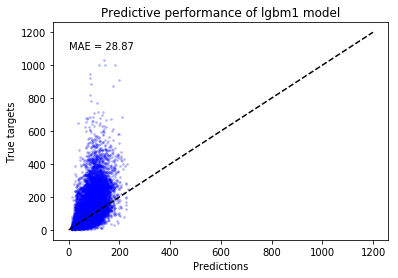

In [16]:
plot_performance(true= y_val, preds= preds, model_name= "lgbm1")

#### Exploring the impact of increasing n-gram range

In [20]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MaxAbsScaler,FunctionTransformer, Imputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import HashingVectorizer

# First we build two utility functions to parse numeric and text data, 
# and wrap them using FunctionTransformer, so that they can be integrated into a sklearn pipeline:
def text_columns(X_train):
    return X_train.TEXT_FEATURES

def numeric_columns(X_train):
    numeric = ['APPLICANT_PRIOR_CLEARANCE_TO_DATE','DEVICENAME_PRIOR_CLEARANCE_TO_DATE']
    temp = X_train[numeric]
    return temp

get_numeric_data = FunctionTransformer(func = numeric_columns, validate=False) 
get_text_data = FunctionTransformer(func = text_columns,validate=False) 
# Note how we avoid putting any arguments into text_columns and numeric_columns

# We also need to create our regex token pattern to use in HashingVectorizer. 
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'   
#Note this regex will match either a whitespace or a punctuation to tokenize the string vector on these preferences  

# We also need to redefine the default feature selection function for regression to properly place into our pipeline:
def f_regression(X,Y):
    import sklearn
    return sklearn.feature_selection.f_regression(X,Y,center = False) # default is center = True


pipeline510k_tree4 = Pipeline([
    
    ("union",FeatureUnion( # Note that FeatureUnion() accepts list of tuples, the first half of each tuple is the name of the transformer
        
        transformer_list = [
            
            ("numeric_subpipeline", Pipeline([ # Note we have subpipeline branches inside the main pipeline
                
                ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                ("imputer",Imputer()), # Step2: impute missing values (we don't expect any)
            
            ])), # Branching point of the FeatureUnion
            
            ("text_subpipeline",Pipeline([
            
                ("parser",get_text_data), # Step1: parse the text data 
                ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC,n_features= 2* (2 ** 18),decode_error='ignore',
                                             stop_words = "english",# We will remove English stop words before tokenization
                                             ngram_range = (1,2), # We will tokenize up to 2-grams
                                             non_negative=True, norm=None, binary=True  
                                            )) # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                           
                
            ]))
        ]
    
    )),# Branching point to the main pipeline: at this point all features are numeric
    
    ("scaler",MaxAbsScaler()) # Scale the features
])


In [21]:
import datetime
from warnings import filterwarnings

filterwarnings("ignore")

start = datetime.datetime.now()

X_train_trans_tree4 = pipeline510k_tree4.fit(X_train, y_train).transform(X_train)

end = datetime.datetime.now()
print("Completed processing X_train in: " + str((end-start).seconds/60) + " minutes.")

start = datetime.datetime.now()

X_val_trans_tree4 = pipeline510k_tree4.transform(X_val)

end = datetime.datetime.now()
print("Completed processing X_val in: " + str((end-start).seconds/60) + " minutes.")

Completed processing X_train in: 1.3666666666666667 minutes.
Completed processing X_val in: 0.31666666666666665 minutes.


In [22]:
print(X_train_trans_tree4.shape)
print(X_val_trans_tree4.shape)

(32275, 524290)
(15899, 524290)


In [23]:
n_features_list = [300,5000,10000,20000,50000,100000,200000,400000,500000]
mae_list = []
time_list = []

for n_features in n_features_list:
    print("Training model using "+ str(n_features))
    
    # Testing feature selection based on training set
    Xt = SelectKBest(f_regression,n_features).fit(X_train_trans_tree4,y_train).transform(X_train_trans_tree4)
    Xv = SelectKBest(f_regression,n_features).fit(X_train_trans_tree4,y_train).transform(X_val_trans_tree4)

    start = datetime.datetime.now()
    
    # Fixed model structure 
    lgbm1 = lgb.LGBMRegressor(objective= 'regression', num_leaves= 300,
                              n_estimators=200, reg_alpha= 0.1,
                              boosting_type= 'dart')

    lgbm1.fit(Xt, np.log(y_train))
    preds = lgbm1.predict(Xv)

    # Out-of-box performance using validation set
    mae = median_absolute_error(y_val,np.exp(preds))

    end = datetime.datetime.now()
    
    mae_list.append(mae)
    time_list.append((end-start).seconds/60)

    print("Completed model fit and predictions using "+ str(n_features) + " in: " + str((end-start).seconds/60) + " minutes.")
    print("Median Absolute Error: ", str(mae))
    print("*" * 50)


Training model using 300
Completed model fit and predictions using 300 in: 0.08333333333333333 minutes.
Median Absolute Error:  33.974917755729656
**************************************************
Training model using 5000
Completed model fit and predictions using 5000 in: 1.0833333333333333 minutes.
Median Absolute Error:  29.89808183308346
**************************************************
Training model using 10000
Completed model fit and predictions using 10000 in: 1.6833333333333333 minutes.
Median Absolute Error:  29.607067567619367
**************************************************
Training model using 20000
Completed model fit and predictions using 20000 in: 2.85 minutes.
Median Absolute Error:  29.409841254671164
**************************************************
Training model using 50000
Completed model fit and predictions using 50000 in: 3.6166666666666667 minutes.
Median Absolute Error:  29.03743313015282
**************************************************
Training model u

Let's try using up to 2-grams and selecting for 50000 features and test the model performance once again.

In [5]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MaxAbsScaler,FunctionTransformer, Imputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import HashingVectorizer

# First we build two utility functions to parse numeric and text data, 
# and wrap them using FunctionTransformer, so that they can be integrated into a sklearn pipeline:
def text_columns(X_train):
    return X_train.TEXT_FEATURES

def numeric_columns(X_train):
    numeric = ['APPLICANT_PRIOR_CLEARANCE_TO_DATE','DEVICENAME_PRIOR_CLEARANCE_TO_DATE']
    temp = X_train[numeric]
    return temp

get_numeric_data = FunctionTransformer(func = numeric_columns, validate=False) 
get_text_data = FunctionTransformer(func = text_columns,validate=False) 
# Note how we avoid putting any arguments into text_columns and numeric_columns

# We also need to create our regex token pattern to use in HashingVectorizer. 
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'   
#Note this regefrom sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MaxAbsScaler,FunctionTransformer, Imputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import HashingVectorizer

# First we build two utility functions to parse numeric and text data, 
# and wrap them using FunctionTransformer, so that they can be integrated into a sklearn pipeline:
def text_columns(X_train):
    return X_train.TEXT_FEATURES

def numeric_columns(X_train):
    numeric = ['APPLICANT_PRIOR_CLEARANCE_TO_DATE','DEVICENAME_PRIOR_CLEARANCE_TO_DATE']
    temp = X_train[numeric]
    return temp

get_numeric_data = FunctionTransformer(func = numeric_columns, validate=False) 
get_text_data = FunctionTransformer(func = text_columns,validate=False) 
# Note how we avoid putting any arguments into text_columns and numeric_columns

# We also need to create our regex token pattern to use in HashingVectorizer. 
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'   
#Note this regex will match either a whitespace or a punctuation to tokenize the string vector on these preferences  

# We also need to redefine the default feature selection function for regression to properly place into our pipeline:
def f_regression(X,Y):
    import sklearn
    return sklearn.feature_selection.f_regression(X,Y,center = False) # default is center = True


pipeline510k_tree5 = Pipeline([
    
    ("union",FeatureUnion( # Note that FeatureUnion() accepts list of tuples, the first half of each tuple is the name of the transformer
        
        transformer_list = [
            
            ("numeric_subpipeline", Pipeline([ # Note we have subpipeline branches inside the main pipeline
                
                ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                ("imputer",Imputer()), # Step2: impute missing values (we don't expect any)
            
            ])), # Branching point of the FeatureUnion
            
            ("text_subpipeline",Pipeline([
            
                ("parser",get_text_data), # Step1: parse the text data 
                ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC,n_features= 2* (2 ** 18),decode_error='ignore',
                                             stop_words = "english",# We will remove English stop words before tokenization
                                             ngram_range = (1,2), # We will tokenize up to 2-grams
                                             non_negative=True, norm=None, binary=True  
                                            )) # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                           
                
            ]))
        ]
    
    )),# Branching point to the main pipeline: at this point all features are numeric
    
    ("scaler",MaxAbsScaler()), # Scale the features
    ("dim_red", SelectKBest(f_regression,50000))
])


# We also need to redefine the default feature selection function for regression to properly place into our pipeline:
def f_regression(X,Y):
    import sklearn
    return sklearn.feature_selection.f_regression(X,Y,center = False) # default is center = True


pipeline510k_tree5 = Pipeline([
    
    ("union",FeatureUnion( # Note that FeatureUnion() accepts list of tuples, the first half of each tuple is the name of the transformer
        
        transformer_list = [
            
            ("numeric_subpipeline", Pipeline([ # Note we have subpipeline branches inside the main pipeline
                
                ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                ("imputer",Imputer()), # Step2: impute missing values (we don't expect any)
            
            ])), # Branching point of the FeatureUnion
            
            ("text_subpipeline",Pipeline([
            
                ("parser",get_text_data), # Step1: parse the text data 
                ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC,n_features= 2* (2 ** 18),decode_error='ignore',
                                             stop_words = "english",# We will remove English stop words before tokenization
                                             ngram_range = (1,2), # We will tokenize up to 2-grams
                                             non_negative=True, norm=None, binary=True  
                                            )) # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                           
                
            ]))
        ]
    
    )),# Branching point to the main pipeline: at this point all features are numeric
    
    ("scaler",MaxAbsScaler()), # Scale the features
    ("dim_red", SelectKBest(f_regression,50000))
])


In [30]:
import datetime
from warnings import filterwarnings

filterwarnings("ignore")

start = datetime.datetime.now()

X_train_trans_tree5 = pipeline510k_tree5.fit(X_train, y_train).transform(X_train)

end = datetime.datetime.now()
print("Completed processing X_train in: " + str((end-start).seconds/60) + " minutes.")

start = datetime.datetime.now()

X_val_trans_tree5 = pipeline510k_tree5.transform(X_val)

end = datetime.datetime.now()
print("Completed processing X_val in: " + str((end-start).seconds/60) + " minutes.")

Completed processing X_train in: 1.5 minutes.
Completed processing X_val in: 0.35 minutes.


In [31]:
print(X_train_trans_tree5.shape)
print(X_val_trans_tree5.shape)

(32275, 50000)
(15899, 50000)


In [32]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import median_absolute_error
import datetime
import warnings

start = datetime.datetime.now()

lgbm1 = lgb.LGBMRegressor(objective= 'regression', num_leaves= 294,
                              learning_rate= 0.0983,reg_lambda= 0.0046,
                              min_split_gain = 0.0044, max_depth = 24,
                              colsample_bytree = 0.6014,
                              min_child_samples = 25,
                              min_child_weight = 0.0024,subsample =  0.5759,
                              n_estimators= 226, reg_alpha= 0.0024,
                              boosting_type= 'dart')

lgbm1.fit(X_train_trans_tree5, np.log(y_train))
preds = lgbm1.predict(X_val_trans_tree5)

# Out-of-box performance using validation set
mae = median_absolute_error(y_val,np.exp(preds))

end = datetime.datetime.now()
print("Median Absolute Error: ", str(mae))
print("Completed model fit and predictions in: " + str((end-start).seconds/60) + " minutes.")

Median Absolute Error:  28.977003691917247
Completed model fit and predictions in: 2.5 minutes.


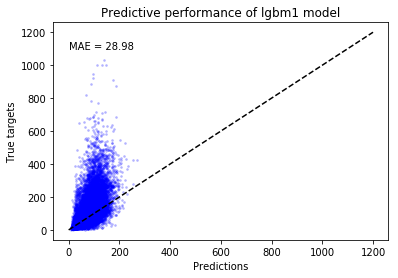

In [33]:
plot_performance(true= y_val, preds= preds, model_name= "lgbm1")

### Conclusions and final model 

Performance is similar to earlier tuned model. We will re-train and save the tuned model along with the data sets and pipeline 3 we used above. This gives a validation median abosulte error of 28.87 calendar days.

In [38]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import median_absolute_error
import datetime
import warnings

start = datetime.datetime.now()

lgbm1 = lgb.LGBMRegressor(objective= 'regression', num_leaves= 294,
                              learning_rate= 0.0983,reg_lambda= 0.0046,
                              min_split_gain = 0.0044, max_depth = 24,
                              colsample_bytree = 0.6014,
                              min_child_samples = 25,
                              min_child_weight = 0.0024,subsample =  0.5759,
                              n_estimators= 226, reg_alpha= 0.0024,
                              boosting_type= 'dart')

lgbm1.fit(X_train_trans_tree3, np.log(y_train))
preds = lgbm1.predict(X_val_trans_tree3)

# Out-of-box performance using validation set
mae = median_absolute_error(y_val,np.exp(preds))

end = datetime.datetime.now()
print("Median Absolute Error: ", str(mae))
print("Completed model fit and predictions in: " + str((end-start).seconds/60) + " minutes.")

Median Absolute Error:  28.874978339393977
Completed model fit and predictions in: 1.35 minutes.


In [43]:
# Save the work into a dedicated workspace "tree"
Rea
import pickle
import os
if not os.path.exists(disk_tree):
    os.makedirs(disk_tree)

# Save the pipeline
with open(disk_tree + "\pipeline510k_tree3.pkl", "wb") as f:
    pickle.dump(pipeline510k_tree3,f)

print("Saved the pipeline.")
print("*" * 40)

# Save the model
with open(disk_tree + "/lgbm1_model.pkl", "wb") as f:
    pickle.dump(lgbm1,f)

print("Saved the model.")    
print("*" * 40)

# Save transformed data sets
with open(disk_tree + "\X_train_trans_tree3.pkl", "wb") as f:
    pickle.dump(X_train_trans_tree3,f)
    
with open(disk_tree + "\X_val_trans_tree3.pkl", "wb") as f:
    pickle.dump(X_val_trans_tree3,f) 
    
print("Saved the transformed data sets.")   
print("*" * 40)

Saved the pipeline.
****************************************
Saved the model.
****************************************
Saved the transformed data sets.
****************************************


## Save python 2-friendly pickle model and pipeline

Since some systems use python 2 instead of python 3, we need to re-pickle the pipeline and model objects. This is because the protocol python 3 uses is number 3 by default, by python 2 only has protocols 0,1, and 2.

In [8]:
import pickle
disk_tree = "tree"
# Read the pipeline
with open(disk_tree + "\pipeline510k_tree3.pkl", "rb") as f:
    pipeline510k_tree3=pickle.load(f)
    
# Save python2-friendly version    
with open(disk_tree + "\pipeline510k_tree3_py2.pkl", "wb") as f:
    pickle.dump(pipeline510k_tree3,f,protocol=1) 
    
# Read the model
with open(disk_tree + "/lgbm1_model.pkl", "rb") as f:
    lgbm1=pickle.load(f)
    
# Save python2-friendly version    
with open(disk_tree + "/lgbm1_model_py2.pkl", "wb") as f:
    pickle.dump(lgbm1,f,protocol=1)     